In [1]:
import os
from os.path import expanduser
home_dir = expanduser("~")
module_path = home_dir + '/code/modules/'
models_path = home_dir + '/models/'
import sys
sys.path.append(module_path)
fig_dir = 'figures/'
import time
import importlib
import random
import tensorflow as tf
import pandas as pd
from keras import regularizers
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Dense, LeakyReLU, concatenate
from keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
#import model_management
from scipy.special import comb
import datetime
import codecs, json
import corner
from itertools import combinations
%load_ext autoreload
%autoreload 1
%aimport data_processing
%aimport plotting
%aimport keras_objects
%aimport model_setup
from data_processing import *
from plotting import *
from keras_objects import *
from model_setup import *

np.random.seed(999)
random.seed(999)

Using TensorFlow backend.


In [ ]:
### Run on CPU only
os.environ["CUDA_VISIBLE_DEVICES"] = ""

## Set parameter string

In [ ]:
### Set name ending with parameters for figures to be saved
param_string = 'nLayers_%d_nNeurons_%d_actFun_%s_lossFunc_%s_nTrainSamples_%d_nEpochs_%d_batchSize_%d' % (
    nLayers, neuronsPerLayer, activationFunction, loss_function, train_size, nEpochs, batchSize)
print(param_string)

In [ ]:
print(np.mean(y_test_norm, 0))
print(np.std(y_test_norm, 0))
print(np.min(x_test_norm, 0))
print(np.max(x_test_norm, 0))

In [ ]:
### Get a feel for the data
for i in range(len(input_features)):
    print(input_features[i],': min: %.2e, max: %.2e.' % (np.min(x_train[:,i]), np.max(x_train[:,i])))
for i in range(len(output_features)):
    print(output_features[i],': min: %.2e, max: %.2e.' % (np.min(y_train[:,i]), np.max(y_train[:,i])))

In [ ]:
### Visualisation for when we have 2 input features
%matplotlib notebook
input_feat_1 = 0
input_feat_2 = 1
output_feat = 1

fig = plt.figure(1, figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_train_norm[:500,input_feat_1], x_train_norm[:500,input_feat_2], 
           y_train_norm[:500,output_feat])
ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_1]))
ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[input_feat_2]))
ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[output_feat]))
plt.show()

## Load an existing model

In [ ]:
model = load_model()

In [ ]:
### Search for the model that you want
importlib.reload(model_management)
search_dict = {
    'training_method': 'backprop'
}
[model_dicts, description_dicts] = model_management.SearchModel(search_dict, get_hits=True)
print(description_dicts)
print('\n')
for key in model_dicts:
    print(key)
    print(model_dicts[key])
    print('\n')


In [ ]:
importlib.reload(model_management)
model, model_dict, description = model_management.LoadModel(search_dict, 1)

## Get the standard pictures

In [24]:
mode = 'test' # 'train', 'val, 'test'

In [25]:
norm_scores = model.evaluate(x=training_data_dict['input_test_dict'], y=training_data_dict['output_test_dict'],
                                               verbose=1)
tot_score = norm_scores[0]
predicted_points = predict_points(model, training_data_dict, data_type = mode)
title = 'Inputs: %s\n%.1e train points, test mse %.3e, %s data' % (', '.join(input_features), train_size, tot_score, mode)

100000/100000 [==============================] - 10s 104us/step


/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


<function matplotlib.pyplot.show>

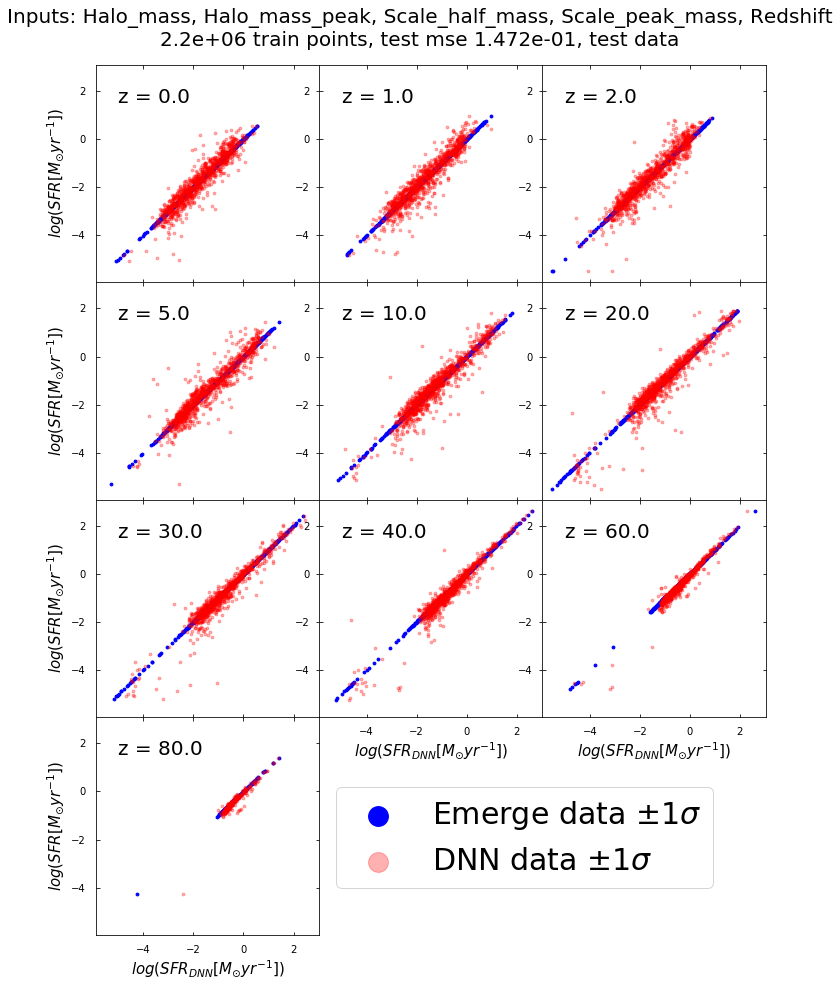

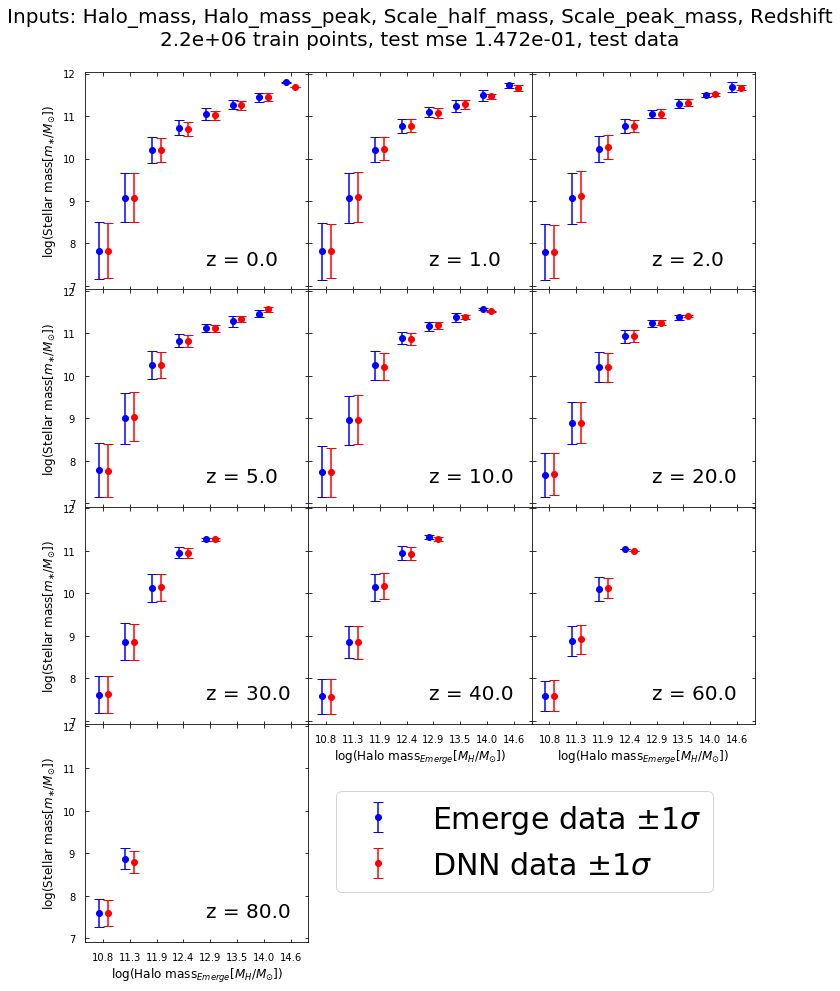

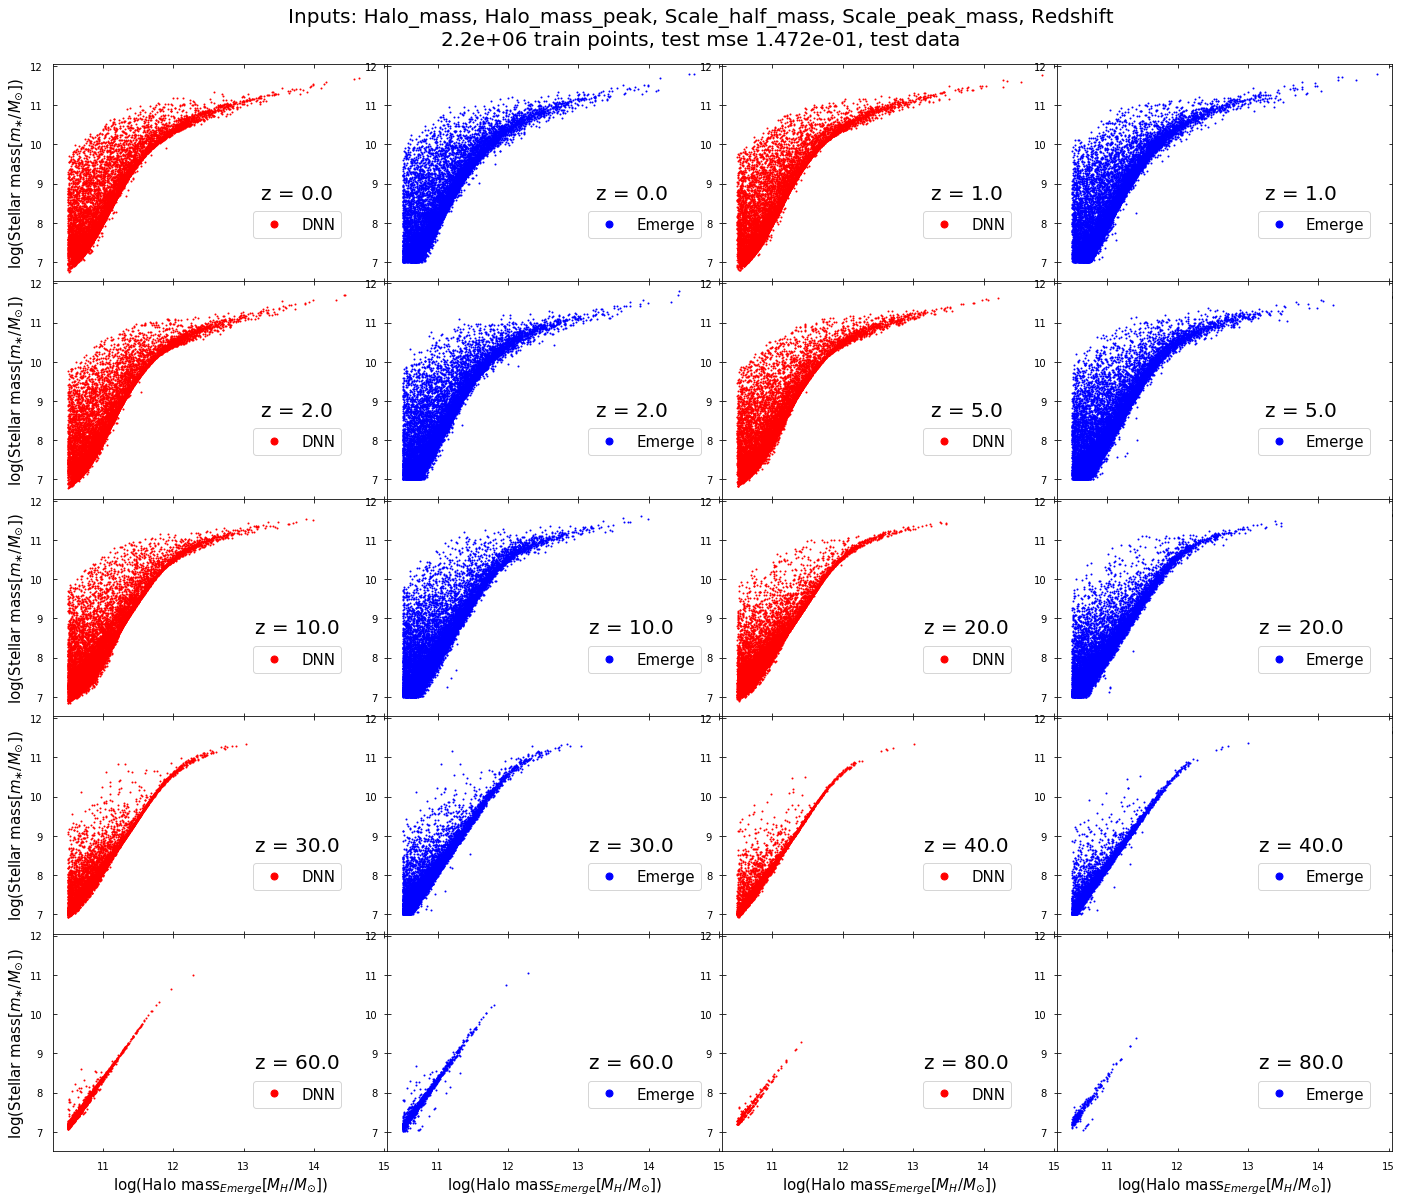

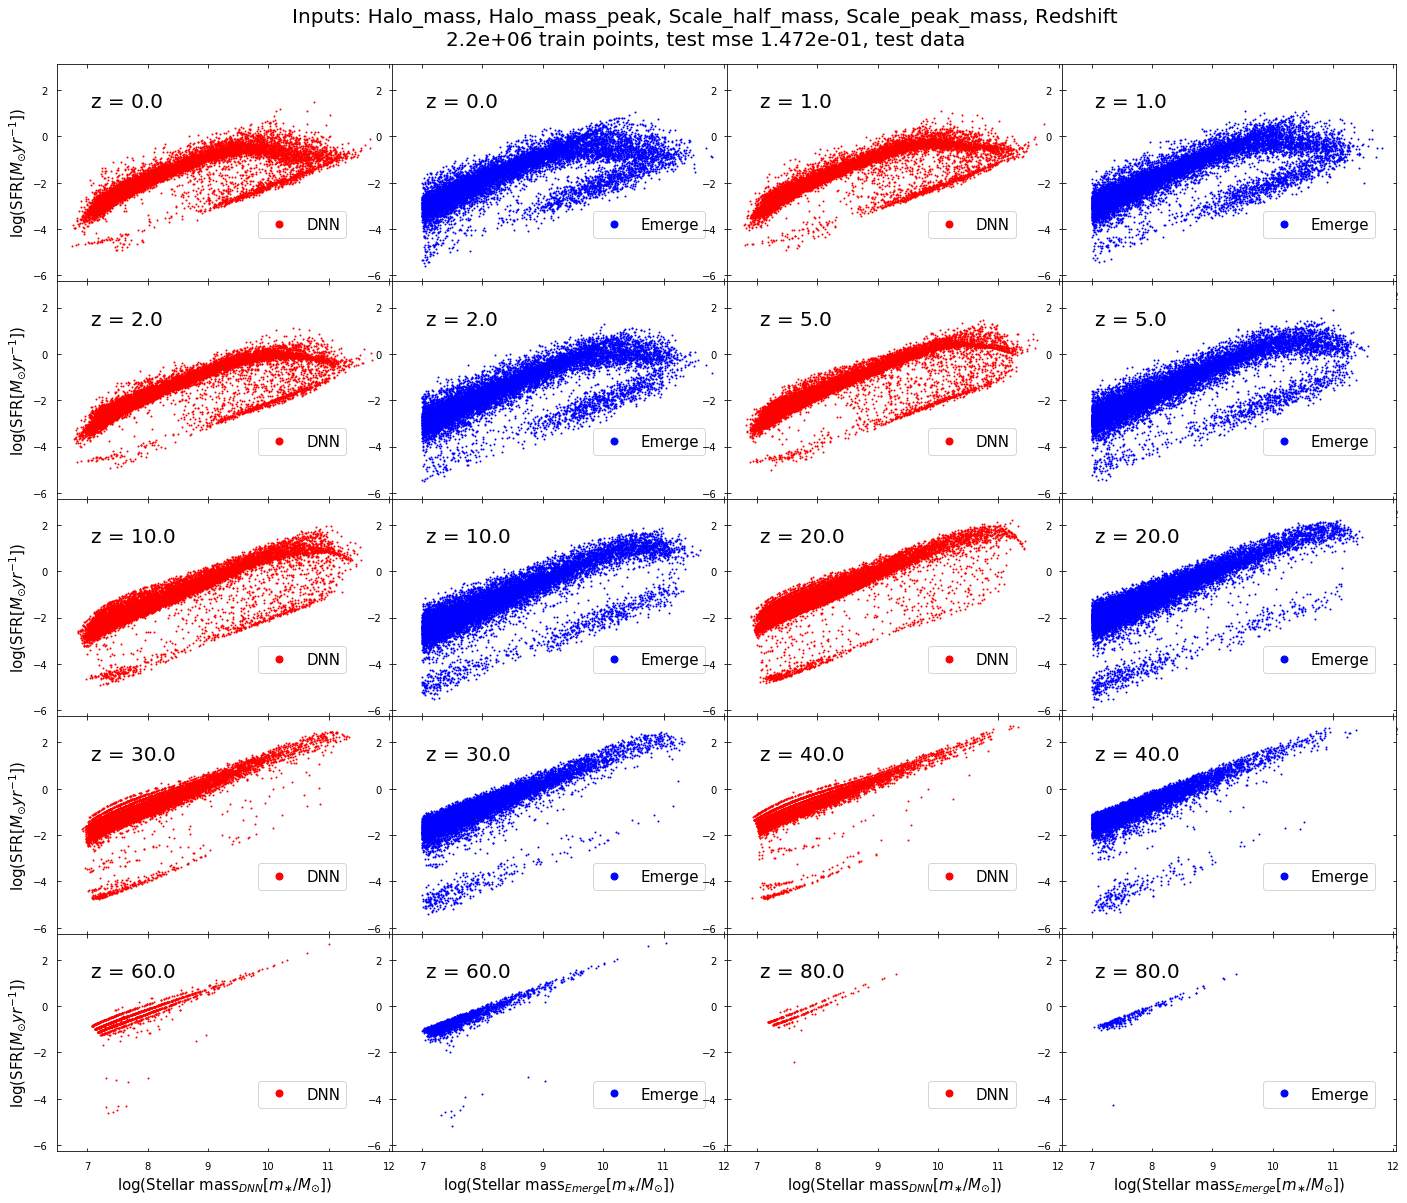

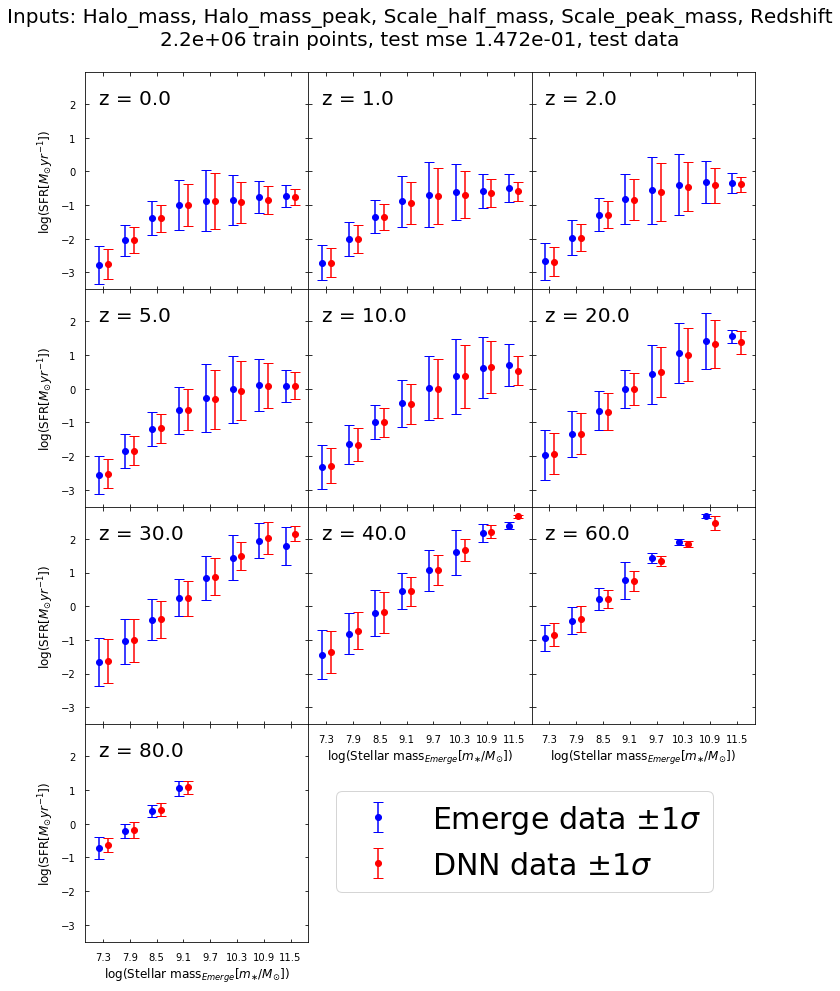

In [38]:
### Standard plots
fig1 = get_pred_vs_real_scatterplot(model, training_data_dict, unit_dict, data_keys, 'SFR', title=title, data_type=mode,
                                   predicted_points = predicted_points)
fig2 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'Stellar_mass', 
                                binning_feat = 'Halo_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
fig3 = get_halo_stellar_mass_plots(model, training_data_dict, unit_dict, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig4 = get_stellar_mass_sfr_plots(model, training_data_dict, unit_dict, title=title, y_max = None, y_min = None,
                                    x_min = None, x_max = None, data_type=mode, predicted_points = predicted_points)
fig5 = get_real_vs_pred_boxplot(model, training_data_dict, unit_dict, data_keys, predicted_feat = 'SFR', 
                                binning_feat = 'Stellar_mass', title=title, data_type=mode,
                                predicted_points = predicted_points)
plt.show

In [ ]:
fig6 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Halo_mass', 
                                 y_axis_feature = 'Stellar_mass', title=title, data_type=mode, marker_size=5,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
fig7 = get_real_vs_pred_same_fig(model, training_data_dict, unit_dict, x_axis_feature='Stellar_mass', 
                                 y_axis_feature = 'SFR', title=title, data_type=mode, marker_size=2,
                                 y_min=None, y_max=None, x_min=None, x_max=None)
plt.show

In [ ]:
fig8, fig9 = get_sfr_stellar_mass_contour(model, training_data_dict, unit_dict, title=None, data_type='test',
                                 y_min=None, y_max=None, x_min=None, x_max=None, predicted_points=predicted_points)

In [39]:
### Save the figures
date_string = datetime.datetime.now().strftime('%H-%M_%Y-%m-%d')
fig1.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_true_pred_sfr_scatter.png', bbox_inches = 'tight')
fig2.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) + '_boxplot_stellar_mass.png', bbox_inches = 'tight')
fig3.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_halo_vs_stellar_mass.png', bbox_inches = 'tight')
fig4.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_boxplot_sfr.png', bbox_inches = 'tight')
fig5.savefig(fig_dir + date_string + '_' + '_'.join(input_features) + '_to_' + '_'.join(output_features) +'_scatter_comp_stellar_mass_vs_sfr.png', bbox_inches = 'tight')

## Set model parameters

In [20]:
### General parameters
nr_steps = 5e4
nr_repetitions = 1
batch_size = 5e4
total_set_size = 2.4e6 # how many examples will be used for training+validation+testing
train_size = 2.2e6
val_size = .1e6
test_size = .1e6
norm = {'input': 'zero_mean_unit_std',
        'output': 'none'} # 'none',   'zero_mean_unit_std',   'zero_to_one'
input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_half_mass', 'Scale_peak_mass', 'Redshift']
output_features = ['Stellar_mass', 'SFR']
redshifts = [0,1,2,5,10,20,30,40,60,80]

outputs_to_weigh = ['Stellar_mass']
weigh_by_redshift = True

nr_epochs = nr_steps * batch_size / train_size

early_stop_patience = 10
early_stop_monitor = 'val_loss'
early_stop_min_delta = 1e-16

validation_data = 'val' #'val' is normally used, use 'train' to check overfitting potential

### Network parameters
nr_layers = 10
activation_function = 'tanh'
output_activation = {'SFR': None, 'Stellar_mass': None}
neurons_per_layer = 30
reg_strength = 0#1e-5


## Load data

In [21]:
# load the selected galaxyfile
galaxies, data_keys, unit_dict = load_galfiles(redshifts=redshifts, equal_numbers=False)
    
# prepare the training data
training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, redshifts,
                                       int(total_set_size), int(train_size), int(val_size), int(test_size))
#galaxies = None
training_data_dict = normalise_data(training_data_dict, norm)

## Create model

In [22]:
model = standard_network(input_features, output_features, neurons_per_layer, nr_layers, activation_function, 
                         output_activation, reg_strength)
#model.summary()

## Train model

In [23]:
earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
#file_path = models_path + "model_checkpoint.hdf5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', save_best_only=True, mode='min', period=10)
#callbacks_list = [earlystop, checkpoint]
callbacks_list = [earlystop]

train_weights, val_weights = get_weights(training_data_dict, output_features, outputs_to_weigh, 
                                         weigh_by_redshift=weigh_by_redshift)

for i_rep in range(1, nr_repetitions+1):
    
    
    history = model.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                        validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                        training_data_dict['output_'+validation_data+'_dict'], val_weights), 
                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list,
                        sample_weight=train_weights, verbose=1)
    #fig = get_scatter_comparison_plots(model, training_data_dict, unit_dict, x_axis_feature = 'Stellar_mass', 
    #                                y_axis_feature = 'SFR', title='rep %d/%d'%(i_rep,nr_repetitions), y_max = None, 
    #                                y_min = None,
    #                                x_min = None, x_max = None, data_type='val')
    #plt.show()

Train on 2200000 samples, validate on 100000 samples
Epoch 1/1136
2200000/2200000 [==============================] - 3s 1us/step - loss: 3.1980e-05 - Stellar_mass_loss: 3.0978e-05 - SFR_loss: 1.0020e-06 - val_loss: 4.9357e-04 - val_Stellar_mass_loss: 4.7696e-04 - val_SFR_loss: 1.6606e-05
Epoch 2/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2568e-05 - Stellar_mass_loss: 1.1918e-05 - SFR_loss: 6.4961e-07 - val_loss: 1.3025e-04 - val_Stellar_mass_loss: 1.1743e-04 - val_SFR_loss: 1.2825e-05
Epoch 3/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 3.6996e-06 - Stellar_mass_loss: 3.1651e-06 - SFR_loss: 5.3455e-07 - val_loss: 5.1670e-05 - val_Stellar_mass_loss: 4.0000e-05 - val_SFR_loss: 1.1670e-05
Epoch 4/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.8621e-06 - Stellar_mass_loss: 1.3428e-06 - SFR_loss: 5.1924e-07 - val_loss: 3.4220e-05 - val_Stellar_mass_loss: 2.3002e-05 - val_SFR_loss: 1.1218e-05
Epo

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.9144e-07 - Stellar_mass_loss: 1.6509e-08 - SFR_loss: 1.7493e-07 - val_loss: 4.2524e-06 - val_Stellar_mass_loss: 3.7654e-07 - val_SFR_loss: 3.8759e-06
Epoch 36/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.9001e-07 - Stellar_mass_loss: 1.6455e-08 - SFR_loss: 1.7356e-07 - val_loss: 4.2206e-06 - val_Stellar_mass_loss: 3.7460e-07 - val_SFR_loss: 3.8460e-06
Epoch 37/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.8866e-07 - Stellar_mass_loss: 1.6382e-08 - SFR_loss: 1.7228e-07 - val_loss: 4.1912e-06 - val_Stellar_mass_loss: 3.7339e-07 - val_SFR_loss: 3.8178e-06
Epoch 38/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.8737e-07 - Stellar_mass_loss: 1.6328e-08 - SFR_loss: 1.7104e-07 - val_loss: 4.1628e-06 - val_Stellar_mass_loss: 3.7185e-07 - val_SFR_loss: 3.7909e-06
Epoch 39/1136
2200000/2200000 [==============================] - 2

Epoch 70/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.5897e-07 - Stellar_mass_loss: 1.4184e-08 - SFR_loss: 1.4479e-07 - val_loss: 3.5287e-06 - val_Stellar_mass_loss: 3.2152e-07 - val_SFR_loss: 3.2072e-06
Epoch 71/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.5830e-07 - Stellar_mass_loss: 1.4156e-08 - SFR_loss: 1.4414e-07 - val_loss: 3.5130e-06 - val_Stellar_mass_loss: 3.2049e-07 - val_SFR_loss: 3.1925e-06
Epoch 72/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.5762e-07 - Stellar_mass_loss: 1.4119e-08 - SFR_loss: 1.4350e-07 - val_loss: 3.4981e-06 - val_Stellar_mass_loss: 3.1970e-07 - val_SFR_loss: 3.1784e-06
Epoch 73/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.5697e-07 - Stellar_mass_loss: 1.4086e-08 - SFR_loss: 1.4288e-07 - val_loss: 3.4837e-06 - val_Stellar_mass_loss: 3.1880e-07 - val_SFR_loss: 3.1649e-06
Epoch 74/1136
2200000/2200000 [=====================

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.3954e-07 - Stellar_mass_loss: 1.2131e-08 - SFR_loss: 1.2740e-07 - val_loss: 3.0949e-06 - val_Stellar_mass_loss: 2.7447e-07 - val_SFR_loss: 2.8204e-06
Epoch 105/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.3908e-07 - Stellar_mass_loss: 1.2063e-08 - SFR_loss: 1.2701e-07 - val_loss: 3.0830e-06 - val_Stellar_mass_loss: 2.7240e-07 - val_SFR_loss: 2.8106e-06
Epoch 106/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.3859e-07 - Stellar_mass_loss: 1.1980e-08 - SFR_loss: 1.2661e-07 - val_loss: 3.0726e-06 - val_Stellar_mass_loss: 2.7078e-07 - val_SFR_loss: 2.8019e-06
Epoch 107/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.3814e-07 - Stellar_mass_loss: 1.1908e-08 - SFR_loss: 1.2623e-07 - val_loss: 3.0630e-06 - val_Stellar_mass_loss: 2.6887e-07 - val_SFR_loss: 2.7941e-06
Epoch 108/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2742e-07 - Stellar_mass_loss: 9.8363e-09 - SFR_loss: 1.1759e-07 - val_loss: 2.8235e-06 - val_Stellar_mass_loss: 2.2386e-07 - val_SFR_loss: 2.5997e-06
Epoch 139/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2716e-07 - Stellar_mass_loss: 9.7864e-09 - SFR_loss: 1.1737e-07 - val_loss: 2.8191e-06 - val_Stellar_mass_loss: 2.2250e-07 - val_SFR_loss: 2.5966e-06
Epoch 140/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2692e-07 - Stellar_mass_loss: 9.7394e-09 - SFR_loss: 1.1718e-07 - val_loss: 2.8132e-06 - val_Stellar_mass_loss: 2.2124e-07 - val_SFR_loss: 2.5919e-06
Epoch 141/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2668e-07 - Stellar_mass_loss: 9.6959e-09 - SFR_loss: 1.1698e-07 - val_loss: 2.8090e-06 - val_Stellar_mass_loss: 2.2042e-07 - val_SFR_loss: 2.5886e-06
Epoch 142/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2076e-07 - Stellar_mass_loss: 8.7592e-09 - SFR_loss: 1.1200e-07 - val_loss: 2.6738e-06 - val_Stellar_mass_loss: 2.0035e-07 - val_SFR_loss: 2.4734e-06
Epoch 173/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2060e-07 - Stellar_mass_loss: 8.7372e-09 - SFR_loss: 1.1186e-07 - val_loss: 2.6744e-06 - val_Stellar_mass_loss: 2.0040e-07 - val_SFR_loss: 2.4740e-06
Epoch 174/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2045e-07 - Stellar_mass_loss: 8.7237e-09 - SFR_loss: 1.1173e-07 - val_loss: 2.6669e-06 - val_Stellar_mass_loss: 1.9924e-07 - val_SFR_loss: 2.4676e-06
Epoch 175/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.2031e-07 - Stellar_mass_loss: 8.7093e-09 - SFR_loss: 1.1160e-07 - val_loss: 2.6655e-06 - val_Stellar_mass_loss: 1.9923e-07 - val_SFR_loss: 2.4663e-06
Epoch 176/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1616e-07 - Stellar_mass_loss: 8.3167e-09 - SFR_loss: 1.0784e-07 - val_loss: 2.5704e-06 - val_Stellar_mass_loss: 1.9012e-07 - val_SFR_loss: 2.3803e-06
Epoch 207/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1604e-07 - Stellar_mass_loss: 8.3104e-09 - SFR_loss: 1.0773e-07 - val_loss: 2.5675e-06 - val_Stellar_mass_loss: 1.8993e-07 - val_SFR_loss: 2.3776e-06
Epoch 208/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1593e-07 - Stellar_mass_loss: 8.3020e-09 - SFR_loss: 1.0763e-07 - val_loss: 2.5663e-06 - val_Stellar_mass_loss: 1.8980e-07 - val_SFR_loss: 2.3765e-06
Epoch 209/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1585e-07 - Stellar_mass_loss: 8.2944e-09 - SFR_loss: 1.0756e-07 - val_loss: 2.5637e-06 - val_Stellar_mass_loss: 1.8963e-07 - val_SFR_loss: 2.3741e-06
Epoch 210/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1240e-07 - Stellar_mass_loss: 8.0663e-09 - SFR_loss: 1.0433e-07 - val_loss: 2.4840e-06 - val_Stellar_mass_loss: 1.8380e-07 - val_SFR_loss: 2.3002e-06
Epoch 241/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1227e-07 - Stellar_mass_loss: 8.0597e-09 - SFR_loss: 1.0421e-07 - val_loss: 2.4824e-06 - val_Stellar_mass_loss: 1.8388e-07 - val_SFR_loss: 2.2985e-06
Epoch 242/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1221e-07 - Stellar_mass_loss: 8.0594e-09 - SFR_loss: 1.0415e-07 - val_loss: 2.4811e-06 - val_Stellar_mass_loss: 1.8362e-07 - val_SFR_loss: 2.2975e-06
Epoch 243/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.1211e-07 - Stellar_mass_loss: 8.0530e-09 - SFR_loss: 1.0405e-07 - val_loss: 2.4790e-06 - val_Stellar_mass_loss: 1.8339e-07 - val_SFR_loss: 2.2956e-06
Epoch 244/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0906e-07 - Stellar_mass_loss: 7.8890e-09 - SFR_loss: 1.0117e-07 - val_loss: 2.4104e-06 - val_Stellar_mass_loss: 1.7976e-07 - val_SFR_loss: 2.2306e-06
Epoch 275/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0898e-07 - Stellar_mass_loss: 7.8908e-09 - SFR_loss: 1.0109e-07 - val_loss: 2.4078e-06 - val_Stellar_mass_loss: 1.7945e-07 - val_SFR_loss: 2.2284e-06
Epoch 276/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0889e-07 - Stellar_mass_loss: 7.8845e-09 - SFR_loss: 1.0101e-07 - val_loss: 2.4082e-06 - val_Stellar_mass_loss: 1.7917e-07 - val_SFR_loss: 2.2290e-06
Epoch 277/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0878e-07 - Stellar_mass_loss: 7.8862e-09 - SFR_loss: 1.0089e-07 - val_loss: 2.4047e-06 - val_Stellar_mass_loss: 1.7957e-07 - val_SFR_loss: 2.2251e-06
Epoch 278/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0597e-07 - Stellar_mass_loss: 7.7554e-09 - SFR_loss: 9.8210e-08 - val_loss: 2.3415e-06 - val_Stellar_mass_loss: 1.7578e-07 - val_SFR_loss: 2.1658e-06
Epoch 309/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0584e-07 - Stellar_mass_loss: 7.7520e-09 - SFR_loss: 9.8089e-08 - val_loss: 2.3395e-06 - val_Stellar_mass_loss: 1.7655e-07 - val_SFR_loss: 2.1630e-06
Epoch 310/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0573e-07 - Stellar_mass_loss: 7.7532e-09 - SFR_loss: 9.7972e-08 - val_loss: 2.3367e-06 - val_Stellar_mass_loss: 1.7555e-07 - val_SFR_loss: 2.1612e-06
Epoch 311/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0562e-07 - Stellar_mass_loss: 7.7398e-09 - SFR_loss: 9.7883e-08 - val_loss: 2.3340e-06 - val_Stellar_mass_loss: 1.7562e-07 - val_SFR_loss: 2.1584e-06
Epoch 312/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0261e-07 - Stellar_mass_loss: 7.6405e-09 - SFR_loss: 9.4973e-08 - val_loss: 2.2675e-06 - val_Stellar_mass_loss: 1.7376e-07 - val_SFR_loss: 2.0937e-06
Epoch 343/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0248e-07 - Stellar_mass_loss: 7.6342e-09 - SFR_loss: 9.4846e-08 - val_loss: 2.2644e-06 - val_Stellar_mass_loss: 1.7264e-07 - val_SFR_loss: 2.0918e-06
Epoch 344/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0243e-07 - Stellar_mass_loss: 7.6273e-09 - SFR_loss: 9.4799e-08 - val_loss: 2.2648e-06 - val_Stellar_mass_loss: 1.7304e-07 - val_SFR_loss: 2.0918e-06
Epoch 345/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 1.0225e-07 - Stellar_mass_loss: 7.6269e-09 - SFR_loss: 9.4622e-08 - val_loss: 2.2584e-06 - val_Stellar_mass_loss: 1.7260e-07 - val_SFR_loss: 2.0858e-06
Epoch 346/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 9.8686e-08 - Stellar_mass_loss: 7.5577e-09 - SFR_loss: 9.1129e-08 - val_loss: 2.1786e-06 - val_Stellar_mass_loss: 1.7051e-07 - val_SFR_loss: 2.0080e-06
Epoch 377/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 9.8516e-08 - Stellar_mass_loss: 7.5476e-09 - SFR_loss: 9.0968e-08 - val_loss: 2.1776e-06 - val_Stellar_mass_loss: 1.7096e-07 - val_SFR_loss: 2.0066e-06
Epoch 378/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 9.8459e-08 - Stellar_mass_loss: 7.5543e-09 - SFR_loss: 9.0905e-08 - val_loss: 2.1729e-06 - val_Stellar_mass_loss: 1.7027e-07 - val_SFR_loss: 2.0026e-06
Epoch 379/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 9.8228e-08 - Stellar_mass_loss: 7.5467e-09 - SFR_loss: 9.0681e-08 - val_loss: 2.1722e-06 - val_Stellar_mass_loss: 1.7121e-07 - val_SFR_loss: 2.0010e-06
Epoch 380/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 9.4199e-08 - Stellar_mass_loss: 7.5296e-09 - SFR_loss: 8.6669e-08 - val_loss: 2.0824e-06 - val_Stellar_mass_loss: 1.6927e-07 - val_SFR_loss: 1.9131e-06
Epoch 411/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 9.3994e-08 - Stellar_mass_loss: 7.5222e-09 - SFR_loss: 8.6472e-08 - val_loss: 2.0772e-06 - val_Stellar_mass_loss: 1.6959e-07 - val_SFR_loss: 1.9076e-06
Epoch 412/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 9.3884e-08 - Stellar_mass_loss: 7.5202e-09 - SFR_loss: 8.6363e-08 - val_loss: 2.0771e-06 - val_Stellar_mass_loss: 1.6954e-07 - val_SFR_loss: 1.9075e-06
Epoch 413/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 9.3756e-08 - Stellar_mass_loss: 7.5244e-09 - SFR_loss: 8.6231e-08 - val_loss: 2.0696e-06 - val_Stellar_mass_loss: 1.6915e-07 - val_SFR_loss: 1.9005e-06
Epoch 414/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 8.9841e-08 - Stellar_mass_loss: 7.5152e-09 - SFR_loss: 8.2326e-08 - val_loss: 1.9924e-06 - val_Stellar_mass_loss: 1.7034e-07 - val_SFR_loss: 1.8221e-06
Epoch 445/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.9679e-08 - Stellar_mass_loss: 7.5145e-09 - SFR_loss: 8.2165e-08 - val_loss: 1.9790e-06 - val_Stellar_mass_loss: 1.6876e-07 - val_SFR_loss: 1.8103e-06
Epoch 446/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.9498e-08 - Stellar_mass_loss: 7.5072e-09 - SFR_loss: 8.1991e-08 - val_loss: 1.9776e-06 - val_Stellar_mass_loss: 1.6895e-07 - val_SFR_loss: 1.8086e-06
Epoch 447/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.9376e-08 - Stellar_mass_loss: 7.5077e-09 - SFR_loss: 8.1869e-08 - val_loss: 1.9746e-06 - val_Stellar_mass_loss: 1.6847e-07 - val_SFR_loss: 1.8062e-06
Epoch 448/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 8.5848e-08 - Stellar_mass_loss: 7.4632e-09 - SFR_loss: 7.8385e-08 - val_loss: 1.8951e-06 - val_Stellar_mass_loss: 1.6812e-07 - val_SFR_loss: 1.7270e-06
Epoch 479/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.5714e-08 - Stellar_mass_loss: 7.4580e-09 - SFR_loss: 7.8256e-08 - val_loss: 1.8921e-06 - val_Stellar_mass_loss: 1.6771e-07 - val_SFR_loss: 1.7244e-06
Epoch 480/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.5592e-08 - Stellar_mass_loss: 7.4579e-09 - SFR_loss: 7.8134e-08 - val_loss: 1.8932e-06 - val_Stellar_mass_loss: 1.6799e-07 - val_SFR_loss: 1.7252e-06
Epoch 481/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.5470e-08 - Stellar_mass_loss: 7.4589e-09 - SFR_loss: 7.8011e-08 - val_loss: 1.8890e-06 - val_Stellar_mass_loss: 1.6819e-07 - val_SFR_loss: 1.7209e-06
Epoch 482/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 8.2360e-08 - Stellar_mass_loss: 7.3800e-09 - SFR_loss: 7.4980e-08 - val_loss: 1.8196e-06 - val_Stellar_mass_loss: 1.6655e-07 - val_SFR_loss: 1.6530e-06
Epoch 513/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.2272e-08 - Stellar_mass_loss: 7.3794e-09 - SFR_loss: 7.4893e-08 - val_loss: 1.8172e-06 - val_Stellar_mass_loss: 1.6651e-07 - val_SFR_loss: 1.6507e-06
Epoch 514/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.2149e-08 - Stellar_mass_loss: 7.3728e-09 - SFR_loss: 7.4776e-08 - val_loss: 1.8148e-06 - val_Stellar_mass_loss: 1.6609e-07 - val_SFR_loss: 1.6488e-06
Epoch 515/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 8.2145e-08 - Stellar_mass_loss: 7.3834e-09 - SFR_loss: 7.4762e-08 - val_loss: 1.8239e-06 - val_Stellar_mass_loss: 1.6648e-07 - val_SFR_loss: 1.6574e-06
Epoch 516/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 7.9390e-08 - Stellar_mass_loss: 7.3091e-09 - SFR_loss: 7.2081e-08 - val_loss: 1.7553e-06 - val_Stellar_mass_loss: 1.6467e-07 - val_SFR_loss: 1.5906e-06
Epoch 547/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.9233e-08 - Stellar_mass_loss: 7.2982e-09 - SFR_loss: 7.1935e-08 - val_loss: 1.7488e-06 - val_Stellar_mass_loss: 1.6422e-07 - val_SFR_loss: 1.5846e-06
Epoch 548/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.9102e-08 - Stellar_mass_loss: 7.2891e-09 - SFR_loss: 7.1812e-08 - val_loss: 1.7466e-06 - val_Stellar_mass_loss: 1.6468e-07 - val_SFR_loss: 1.5819e-06
Epoch 549/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.8967e-08 - Stellar_mass_loss: 7.2838e-09 - SFR_loss: 7.1683e-08 - val_loss: 1.7443e-06 - val_Stellar_mass_loss: 1.6431e-07 - val_SFR_loss: 1.5800e-06
Epoch 550/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 7.6550e-08 - Stellar_mass_loss: 7.2177e-09 - SFR_loss: 6.9332e-08 - val_loss: 1.6930e-06 - val_Stellar_mass_loss: 1.6271e-07 - val_SFR_loss: 1.5303e-06
Epoch 581/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.6457e-08 - Stellar_mass_loss: 7.2188e-09 - SFR_loss: 6.9238e-08 - val_loss: 1.6904e-06 - val_Stellar_mass_loss: 1.6298e-07 - val_SFR_loss: 1.5274e-06
Epoch 582/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.6293e-08 - Stellar_mass_loss: 7.2077e-09 - SFR_loss: 6.9085e-08 - val_loss: 1.7101e-06 - val_Stellar_mass_loss: 1.6442e-07 - val_SFR_loss: 1.5457e-06
Epoch 583/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.6350e-08 - Stellar_mass_loss: 7.2095e-09 - SFR_loss: 6.9140e-08 - val_loss: 1.6845e-06 - val_Stellar_mass_loss: 1.6277e-07 - val_SFR_loss: 1.5218e-06
Epoch 584/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 7.3933e-08 - Stellar_mass_loss: 7.1419e-09 - SFR_loss: 6.6791e-08 - val_loss: 1.6355e-06 - val_Stellar_mass_loss: 1.6104e-07 - val_SFR_loss: 1.4744e-06
Epoch 615/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.3782e-08 - Stellar_mass_loss: 7.1410e-09 - SFR_loss: 6.6641e-08 - val_loss: 1.6308e-06 - val_Stellar_mass_loss: 1.6074e-07 - val_SFR_loss: 1.4701e-06
Epoch 616/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.3821e-08 - Stellar_mass_loss: 7.1342e-09 - SFR_loss: 6.6687e-08 - val_loss: 1.6318e-06 - val_Stellar_mass_loss: 1.6071e-07 - val_SFR_loss: 1.4711e-06
Epoch 617/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.3822e-08 - Stellar_mass_loss: 7.1277e-09 - SFR_loss: 6.6694e-08 - val_loss: 1.6286e-06 - val_Stellar_mass_loss: 1.6074e-07 - val_SFR_loss: 1.4678e-06
Epoch 618/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 7.1498e-08 - Stellar_mass_loss: 7.0563e-09 - SFR_loss: 6.4442e-08 - val_loss: 1.5882e-06 - val_Stellar_mass_loss: 1.5901e-07 - val_SFR_loss: 1.4292e-06
Epoch 649/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.1546e-08 - Stellar_mass_loss: 7.0508e-09 - SFR_loss: 6.4495e-08 - val_loss: 1.5821e-06 - val_Stellar_mass_loss: 1.5920e-07 - val_SFR_loss: 1.4229e-06
Epoch 650/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.1300e-08 - Stellar_mass_loss: 7.0499e-09 - SFR_loss: 6.4250e-08 - val_loss: 1.5782e-06 - val_Stellar_mass_loss: 1.5943e-07 - val_SFR_loss: 1.4188e-06
Epoch 651/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 7.1239e-08 - Stellar_mass_loss: 7.0392e-09 - SFR_loss: 6.4199e-08 - val_loss: 1.5856e-06 - val_Stellar_mass_loss: 1.6007e-07 - val_SFR_loss: 1.4255e-06
Epoch 652/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.9244e-08 - Stellar_mass_loss: 6.9711e-09 - SFR_loss: 6.2273e-08 - val_loss: 1.5385e-06 - val_Stellar_mass_loss: 1.5776e-07 - val_SFR_loss: 1.3807e-06
Epoch 683/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.9238e-08 - Stellar_mass_loss: 6.9704e-09 - SFR_loss: 6.2268e-08 - val_loss: 1.5328e-06 - val_Stellar_mass_loss: 1.5763e-07 - val_SFR_loss: 1.3751e-06
Epoch 684/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.9506e-08 - Stellar_mass_loss: 6.9622e-09 - SFR_loss: 6.2544e-08 - val_loss: 1.5386e-06 - val_Stellar_mass_loss: 1.5749e-07 - val_SFR_loss: 1.3811e-06
Epoch 685/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.9184e-08 - Stellar_mass_loss: 6.9619e-09 - SFR_loss: 6.2222e-08 - val_loss: 1.5366e-06 - val_Stellar_mass_loss: 1.5708e-07 - val_SFR_loss: 1.3796e-06
Epoch 686/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.7509e-08 - Stellar_mass_loss: 6.8836e-09 - SFR_loss: 6.0626e-08 - val_loss: 1.4952e-06 - val_Stellar_mass_loss: 1.5590e-07 - val_SFR_loss: 1.3393e-06
Epoch 717/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.7351e-08 - Stellar_mass_loss: 6.8865e-09 - SFR_loss: 6.0464e-08 - val_loss: 1.5013e-06 - val_Stellar_mass_loss: 1.5543e-07 - val_SFR_loss: 1.3458e-06
Epoch 718/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.7350e-08 - Stellar_mass_loss: 6.8814e-09 - SFR_loss: 6.0469e-08 - val_loss: 1.4966e-06 - val_Stellar_mass_loss: 1.5549e-07 - val_SFR_loss: 1.3412e-06
Epoch 719/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.7514e-08 - Stellar_mass_loss: 6.8754e-09 - SFR_loss: 6.0639e-08 - val_loss: 1.4943e-06 - val_Stellar_mass_loss: 1.5615e-07 - val_SFR_loss: 1.3381e-06
Epoch 720/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.6015e-08 - Stellar_mass_loss: 6.8147e-09 - SFR_loss: 5.9201e-08 - val_loss: 1.4619e-06 - val_Stellar_mass_loss: 1.5439e-07 - val_SFR_loss: 1.3075e-06
Epoch 751/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.6046e-08 - Stellar_mass_loss: 6.8100e-09 - SFR_loss: 5.9236e-08 - val_loss: 1.4695e-06 - val_Stellar_mass_loss: 1.5418e-07 - val_SFR_loss: 1.3153e-06
Epoch 752/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.5632e-08 - Stellar_mass_loss: 6.8116e-09 - SFR_loss: 5.8821e-08 - val_loss: 1.4556e-06 - val_Stellar_mass_loss: 1.5395e-07 - val_SFR_loss: 1.3016e-06
Epoch 753/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.5637e-08 - Stellar_mass_loss: 6.8149e-09 - SFR_loss: 5.8823e-08 - val_loss: 1.4559e-06 - val_Stellar_mass_loss: 1.5399e-07 - val_SFR_loss: 1.3019e-06
Epoch 754/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.5376e-08 - Stellar_mass_loss: 6.7622e-09 - SFR_loss: 5.8614e-08 - val_loss: 1.4314e-06 - val_Stellar_mass_loss: 1.5276e-07 - val_SFR_loss: 1.2786e-06
Epoch 785/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.4284e-08 - Stellar_mass_loss: 6.7405e-09 - SFR_loss: 5.7544e-08 - val_loss: 1.4290e-06 - val_Stellar_mass_loss: 1.5280e-07 - val_SFR_loss: 1.2762e-06
Epoch 786/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.5331e-08 - Stellar_mass_loss: 6.7466e-09 - SFR_loss: 5.8585e-08 - val_loss: 1.4868e-06 - val_Stellar_mass_loss: 1.5391e-07 - val_SFR_loss: 1.3329e-06
Epoch 787/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.5032e-08 - Stellar_mass_loss: 6.7450e-09 - SFR_loss: 5.8287e-08 - val_loss: 1.4250e-06 - val_Stellar_mass_loss: 1.5245e-07 - val_SFR_loss: 1.2725e-06
Epoch 788/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.3543e-08 - Stellar_mass_loss: 6.6719e-09 - SFR_loss: 5.6871e-08 - val_loss: 1.4160e-06 - val_Stellar_mass_loss: 1.5082e-07 - val_SFR_loss: 1.2651e-06
Epoch 819/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.3064e-08 - Stellar_mass_loss: 6.6853e-09 - SFR_loss: 5.6379e-08 - val_loss: 1.4088e-06 - val_Stellar_mass_loss: 1.5060e-07 - val_SFR_loss: 1.2582e-06
Epoch 820/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.4576e-08 - Stellar_mass_loss: 6.6878e-09 - SFR_loss: 5.7888e-08 - val_loss: 1.4938e-06 - val_Stellar_mass_loss: 1.5453e-07 - val_SFR_loss: 1.3393e-06
Epoch 821/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.4134e-08 - Stellar_mass_loss: 6.7125e-09 - SFR_loss: 5.7421e-08 - val_loss: 1.4363e-06 - val_Stellar_mass_loss: 1.4987e-07 - val_SFR_loss: 1.2864e-06
Epoch 822/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.2341e-08 - Stellar_mass_loss: 6.6113e-09 - SFR_loss: 5.5729e-08 - val_loss: 1.3961e-06 - val_Stellar_mass_loss: 1.4926e-07 - val_SFR_loss: 1.2469e-06
Epoch 853/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.2117e-08 - Stellar_mass_loss: 6.6167e-09 - SFR_loss: 5.5501e-08 - val_loss: 1.3777e-06 - val_Stellar_mass_loss: 1.4944e-07 - val_SFR_loss: 1.2283e-06
Epoch 854/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1968e-08 - Stellar_mass_loss: 6.6102e-09 - SFR_loss: 5.5358e-08 - val_loss: 1.3786e-06 - val_Stellar_mass_loss: 1.4905e-07 - val_SFR_loss: 1.2296e-06
Epoch 855/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1948e-08 - Stellar_mass_loss: 6.6052e-09 - SFR_loss: 5.5343e-08 - val_loss: 1.3882e-06 - val_Stellar_mass_loss: 1.4908e-07 - val_SFR_loss: 1.2391e-06
Epoch 856/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1172e-08 - Stellar_mass_loss: 6.5611e-09 - SFR_loss: 5.4610e-08 - val_loss: 1.3587e-06 - val_Stellar_mass_loss: 1.4811e-07 - val_SFR_loss: 1.2106e-06
Epoch 887/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1065e-08 - Stellar_mass_loss: 6.5538e-09 - SFR_loss: 5.4511e-08 - val_loss: 1.3633e-06 - val_Stellar_mass_loss: 1.4734e-07 - val_SFR_loss: 1.2160e-06
Epoch 888/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1250e-08 - Stellar_mass_loss: 6.5384e-09 - SFR_loss: 5.4711e-08 - val_loss: 1.3890e-06 - val_Stellar_mass_loss: 1.4816e-07 - val_SFR_loss: 1.2409e-06
Epoch 889/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1263e-08 - Stellar_mass_loss: 6.5512e-09 - SFR_loss: 5.4712e-08 - val_loss: 1.3579e-06 - val_Stellar_mass_loss: 1.4798e-07 - val_SFR_loss: 1.2099e-06
Epoch 890/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 6.1142e-08 - Stellar_mass_loss: 6.4913e-09 - SFR_loss: 5.4651e-08 - val_loss: 1.3887e-06 - val_Stellar_mass_loss: 1.4763e-07 - val_SFR_loss: 1.2411e-06
Epoch 921/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.0831e-08 - Stellar_mass_loss: 6.4977e-09 - SFR_loss: 5.4333e-08 - val_loss: 1.3422e-06 - val_Stellar_mass_loss: 1.4608e-07 - val_SFR_loss: 1.1962e-06
Epoch 922/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.0376e-08 - Stellar_mass_loss: 6.4817e-09 - SFR_loss: 5.3895e-08 - val_loss: 1.3382e-06 - val_Stellar_mass_loss: 1.4598e-07 - val_SFR_loss: 1.1922e-06
Epoch 923/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.8474e-08 - Stellar_mass_loss: 6.9087e-09 - SFR_loss: 6.1566e-08 - val_loss: 1.4546e-06 - val_Stellar_mass_loss: 1.4937e-07 - val_SFR_loss: 1.3052e-06
Epoch 924/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 5.9861e-08 - Stellar_mass_loss: 6.4514e-09 - SFR_loss: 5.3410e-08 - val_loss: 1.3384e-06 - val_Stellar_mass_loss: 1.4475e-07 - val_SFR_loss: 1.1936e-06
Epoch 955/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 5.9607e-08 - Stellar_mass_loss: 6.4311e-09 - SFR_loss: 5.3176e-08 - val_loss: 1.3235e-06 - val_Stellar_mass_loss: 1.4449e-07 - val_SFR_loss: 1.1790e-06
Epoch 956/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 5.9631e-08 - Stellar_mass_loss: 6.4243e-09 - SFR_loss: 5.3207e-08 - val_loss: 1.3431e-06 - val_Stellar_mass_loss: 1.4423e-07 - val_SFR_loss: 1.1988e-06
Epoch 957/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.0010e-08 - Stellar_mass_loss: 6.4296e-09 - SFR_loss: 5.3580e-08 - val_loss: 1.3501e-06 - val_Stellar_mass_loss: 1.4399e-07 - val_SFR_loss: 1.2061e-06
Epoch 958/1136
2200000/2200000 [==============================]

2200000/2200000 [==============================] - 2s 1us/step - loss: 5.9218e-08 - Stellar_mass_loss: 6.3755e-09 - SFR_loss: 5.2843e-08 - val_loss: 1.3106e-06 - val_Stellar_mass_loss: 1.4378e-07 - val_SFR_loss: 1.1668e-06
Epoch 989/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.0600e-08 - Stellar_mass_loss: 6.4171e-09 - SFR_loss: 5.4183e-08 - val_loss: 1.4760e-06 - val_Stellar_mass_loss: 1.5058e-07 - val_SFR_loss: 1.3254e-06
Epoch 990/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 6.0876e-08 - Stellar_mass_loss: 6.5419e-09 - SFR_loss: 5.4334e-08 - val_loss: 1.3177e-06 - val_Stellar_mass_loss: 1.4378e-07 - val_SFR_loss: 1.1740e-06
Epoch 991/1136
2200000/2200000 [==============================] - 2s 1us/step - loss: 5.9130e-08 - Stellar_mass_loss: 6.3775e-09 - SFR_loss: 5.2753e-08 - val_loss: 1.3251e-06 - val_Stellar_mass_loss: 1.4342e-07 - val_SFR_loss: 1.1817e-06
Epoch 992/1136
2200000/2200000 [==============================]

#### Plot loss history

In [ ]:
model.summary()

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
#plt.title(title)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Batch runs

#### Do a batch run to see which input parameters gives the best score

In [ ]:
total_set_size = 300000
train_size = 250000
val_size = 25000
test_size = 25000

core_input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass']
tested_input_features = ['Concentration', 'Type', 'Scale_half_mass', 
                 'Scale_last_MajM', 'Environmental_density']
output_features = ['Stellar_mass', 'SFR']
nr_extra_params_list = [2]
nr_runs_per_comb = 3

nLayers = 10
activationFunction = 'tanh'
neuronsPerLayer = 30
loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
norm = 'zero_to_one' # 'none',   'zero_mean_unit',   'zero_to_one'

nr_steps = 1e4
batch_size = 4e4

verb = 0 # prints progress to stdout

nr_epochs = nr_steps * batch_size / train_size
parameter_dictionary = {
    'fixed_input_features': core_input_features,
    'tested_input_features': tested_input_features,
    'output_features': output_features,
    'nr_extra_parameter_combinations': nr_extra_params_list,
    'nr_steps': [nr_steps],
    'batch_size': [batch_size],
    'nr_epochs': [nr_epochs],
    'nr_training_samples': [train_size],
    'nr_validation_samples': [val_size],
    'nr_test_samples': [test_size],
    'data_normalization': norm,
    'activation_function': activationFunction,
    'neurons_per_layer': [neuronsPerLayer],
    'nr_hidden_layers': [nLayers],
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing three objects. The first one is ' + \
    'the input parameters. The second one is the mse test scores obtained for the different runs evaluated on the ' +\
    'normed units and the original units of the data set (original only if norm is \'none\'). The third one is the ' +\
    'loss histories for the different runs [training_loss, validation_loss] evaluated on the normalised data.'
}
results_list = [parameter_dictionary]
nr_combs_total = 0
for nr_extra_params in nr_extra_params_list:
    nr_combs_total += comb(len(tested_input_features), nr_extra_params)
comb_counter = 0 # to keep track of how many combinations I've gone through

with open('model_comparisons/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_nr_extra_params, nr_extra_params in enumerate(nr_extra_params_list):
        
        extra_param_combs = list(combinations(tested_input_features, nr_extra_params))
        
        date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
        f.write(date_string_proper + '    Testing %d extra parameters. %d/%d extra parameter count tested. \n\n' %
                (nr_extra_params, i_nr_extra_params+1, len(nr_extra_params_list)))
        f.flush()
    
        for i_comb, param_comb in enumerate(extra_param_combs):
            input_features = core_input_features.copy()
            input_features.extend(param_comb)
            
            # prepare the training data
            training_data_dict = divide_train_data(galaxies, data_keys, input_features, output_features, 
                                                   total_set_size, train_size, val_size, test_size)
            training_data_dict = normalise_data(training_data_dict, norm)
            
            date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
            comb_counter += 1
            f.write(date_string_proper + '        Testing combination %d/%d. \n\n' % (comb_counter, nr_combs_total))
            f.flush()
            
            original_scores = []
            if not norm == 'none':
                normed_scores = []
            histories = []

            for i_run in range(nr_runs_per_comb):

                # create model
                model = Sequential()
                model.add(Dense(neuronsPerLayer, input_dim = len(input_features), activation = activationFunction))

                for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
                    model.add(Dense(neuronsPerLayer, activation = activationFunction))

                model.add(Dense(len(output_features)))

                # Compile model
                earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
                callbacks_list = [earlystop]
                model.compile(loss=loss_func_dict[loss_function], optimizer='adam')

                # Fit the model
                if norm == 'none':
                    history = model.fit(training_data_dict['x_train'], training_data_dict['y_train'], 
                                        validation_data=(training_data_dict['x_val'], training_data_dict['y_val']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    orig_score = model.evaluate(x=training_data_dict['x_test'], y=training_data_dict['y_test'],
                                               verbose=verb)
                    original_scores.append(orig_score)
                    
                else:
                    history = model.fit(training_data_dict['x_train_norm'] , training_data_dict['y_train_norm'], 
                                        validation_data=(training_data_dict['x_val_norm'], 
                                        training_data_dict['y_val_norm']), 
                                        epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list, 
                                        verbose=verb)
                    norm_score = model.evaluate(x=training_data_dict['x_test_norm'], y=training_data_dict['y_test_norm'],
                                               verbose=verb)
                    normed_scores.append(norm_score)
                    orig_score = get_test_score(model, training_data_dict, norm)
                    original_scores.append(orig_score)
                    
                histories.append([history.history['loss'], history.history['val_loss']])
                
            if norm == 'none':
                scores = original_scores
            else:
                scores = [normed_scores, original_scores]
                
            results_list.append([input_features, scores, histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

#### Save the result

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('model_comparisons/' + custom_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

In [ ]:

#print(train_loss)
print('Lowest train/val/test loss: %.2f, %.2f, %.2f' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

#### Load a batch run result

In [ ]:
### Load a result
loaded_list_string = '5_total_inputs'
with open('model_comparisons/' + loaded_list_string + '.json', 'r') as f:
    results_list = json.load(f)
f.close()

print(results_list[0])

#### Plot the results

In [ ]:
print(len(results_list[1][1]))
print(results_list[1][1])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached

for comb_nr, lst in enumerate(results_list[1:]):

    title = lst[0]
    train_loss = lst[2][0][0]
    val_loss = lst[2][0][1]
    test_loss = lst[1][0]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for i_run in range(len(test_loss)):
        train_loss = lst[2][i_run][0]
        val_loss = lst[2][i_run][1]
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(results_list[1][0])

In [ ]:
### Get the X best performing input parameters
get_normed_scores = 1
top_nr_of_parameter_combs = 10
column_widths = [0.2, 0.05]
test_results = []
val_results = []
for comb_nr, lst in enumerate(results_list[1:]):
    if get_normed_scores:
        best_test = np.amin(lst[1][0])
    else:
        best_test = np.amin(lst[1][1])
        
#    val_losses = []
#    for i_run in range(len(lst[1])):
#        val_losses.append(lst[2][i_run][1])
        
    test_results.append(best_test)
#    val_results.append(np.amin(val_losses))
    
best_test_indices = np.argsort(test_results)
#best_val_indices = np.argsort(val_results)

fig1362 = plt.figure(figsize=(16,8))

ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best test mse\n(normalised units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_test_indices[i]+1][0][:3])
    inputs = inputs + '\n+\n' + ', '.join(results_list[best_test_indices[i]+1][0][3:])
    
    table_vals.append([inputs, '%.3e' % 
                      (np.amin(results_list[best_test_indices[i]+1][1]))])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 4)
ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization']) +
           '\nFixed input parameters: %s' % (', '.join(results_list[0]['fixed_input_features'])), 
          fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1.15])

plt.show()

In [ ]:
fig1362.savefig(fig_dir + '5_total_inputs' + '_param_comb_scores_test.png', bbox_inches = 'tight')

In [ ]:
### Plot best validation scores
fig2 = plt.figure(figsize=(16,8))


ax = plt.subplot(1,1,1)

collabel=('Input parameters', 'best val mse\n(scaled units)')
table_vals = []
for i in range(top_nr_of_parameter_combs):
    
    inputs = ', '.join(results_list[best_val_indices[i]+1][0])
    
    table_vals.append([inputs, '%.3f' % 
                      (val_results[best_val_indices[i]])])

the_table = ax.table(cellText=table_vals,colLabels=collabel,colWidths=column_widths,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)

ax.axis('tight')
ax.axis('off')
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, relu on output: False, 10 layers, 10 neurons per layer' % 
          (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'], 
          ), fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 1])

#plt.tight_layout(h_pad=30)

plt.show()

In [ ]:
fig2.savefig(fig_dir + '2018-05-12--13-36-02_param_comb_scores_val.png', bbox_inches = 'tight')

In [ ]:
### Find out how a parameter affects the result
collabel = ('Input parameter', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10')
first_col_width = .1
last_col_width = .02
column_widths = [first_col_width]
for i in range(10):
    column_widths.append(last_col_width)
tab_rows = []
row_colours = []

for param in results_list[0]['tested_input_features']:
    
    tab_row = [param]
    row_colour = ['w']

    for i, ind in enumerate(best_test_indices[:10]):
        inputs = results_list[ind+1][0]
        if param in inputs:
            tab_row.append('Yes')
            row_colour.append('g')
        else:
            tab_row.append('No')
            row_colour.append('r')

    tab_rows.append(tab_row)
    row_colours.append(row_colour)
        
fig8845 = plt.figure(figsize=(16,8))

ax = plt.subplot(111)

the_table = ax.table(cellText=tab_rows,colLabels=collabel,colWidths=column_widths,
                     cellColours=row_colours,loc='center')
the_table.set_fontsize(15)
the_table.scale(3, 3)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None,
                wspace=0.2, hspace=0.5)
plt.title('# weight updates: %.1e, batch size: %.1e,\nnorm: %s, output norm: False, 10 layers, 30 neurons per layer'
          % (results_list[0]['nr_steps'][0], results_list[0]['batch_size'][0], results_list[0]['data_normalization'])+
           '\nFixed input parameters: %s\nOrdering based on test scores (normalised units)' % 
          (', '.join(results_list[0]['fixed_input_features'])), fontsize=20)
#plt.title('Ordering based on validation scores', fontsize=20)
ttl = ax.title
ttl.set_position([0.5, 0.8])

#ax.axis('tight')
ax.axis('off')

plt.show()
    

In [ ]:
fig8845.savefig(fig_dir + '5_total_inputs' + '_param_importance_test.png', bbox_inches = 'tight')

## Hyperparameter search

In [ ]:
nr_folds = 1
#total_set_size = int(1e4 + 1/(nr_folds-1)*1e4)
total_set_size = 3.5e4
train_size = 1e4
val_size = 2.5e4
test_size = 0

input_features = ['Halo_mass', 'Halo_mass_peak', 'Scale_peak_mass', 'Scale_half_mass', 'Scale_last_MajM']
output_features = ['Stellar_mass', 'SFR']
outputs_to_weigh = ['Stellar_mass']

nr_layers = [3, 8, 20]
neurons_per_layer = [3, 10, 30]
activation_functions = ['leaky_relu', 'tanh']

loss_function = 'mse' # 'mse', 'weighted_mse_1' 'mae'
input_norms = ['zero_mean_unit_std', 'zero_to_one']
output_activation = {'SFR': None, 'Stellar_mass': None}
reg_strengths = [0, 1e-10, 1e-2]

nr_steps = [5e3]
batch_sizes = np.array([1e3, 5e3, 1e4])
nr_epochs = nr_steps * batch_sizes / train_size
early_stop_patience = 200
early_stop_min_delta = 1e-20

verb = 0 # prints progress to stdout

parameter_dictionary = {
    'input_features': input_features,
    'output_features': output_features,
    'outputs_to_weigh': outputs_to_weigh,
    'loss_function': loss_function,
    'nr_steps': nr_steps,
    'batch_sizes': batch_sizes,
    'nr_epochs': nr_epochs,
    'total_set_size': [total_set_size],
    'reg_strengths': reg_strengths,
    'nr_folds': nr_folds,
    'input_norms': input_norms,
    'activation_functions': activation_functions,
    'neurons_per_layer': neurons_per_layer,
    'nr_hidden_layers': nr_layers,
    'output_activation_function': 'none',
    'description': 'Each parameter setting is represented by one list containing four objects. The first one is ' + \
    'the parameters of the model. The second one is a list with 1: the mean best val score obtained based on the '+\
    'k folds, 2: the std for these scoresl and 3: the best validation score from all folds and histories.' +\
    'The third one is the training' +\
    'loss histories for the different folds and the fourth one is the validation loss histories on the different folds.'
}
results_list = [parameter_dictionary]
tot_nr_runs = len(nr_layers) * len(neurons_per_layer) * len(activation_functions) * len(input_norms) * \
                len(batch_sizes) * len(reg_strengths) * nr_folds
run_counter = 0 # to keep track of how many combinations I've gone through

earlystop = EarlyStopping(monitor='val_loss', min_delta=1e-7, patience=100, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

with open('hyperparameter_searches/progress.txt', 'w+') as f:
    
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark done on input parameters at ' + date_string_proper + '\n\n')
    f.flush()
    
    # load the selected galaxyfile, be sure that the autoloaded galaxyfile is the one that you want to use!!
    galaxies, data_keys, unit_dict = load_galfile()
    
    for i_act_fun, act_fun in enumerate(activation_functions):
        for i_reg_strength, reg_strength in enumerate(reg_strengths):
            for i_inp_norm, inp_norm in enumerate(input_norms):
                norm = {'input': inp_norm,
                        'output': 'none'}
                for i_neur_per_lay, neur_per_lay in enumerate(neurons_per_layer):
                    for i_nr_lay, nr_lay in enumerate(nr_layers):
                        for i_batch_size, batch_size in enumerate(batch_sizes):
                        
                        
                            train_histories = []
                            val_histories = []
                            scores = []
                            
                            for fold in range(nr_folds):
                                
                                date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
                                run_counter += 1
                                f.write(date_string_proper + '        Run nr %d/%d. \n\n' % (run_counter, tot_nr_runs))
                                f.flush()

                                # prepare the training data
                                training_data_dict = divide_train_data(galaxies, data_keys, input_features, 
                                                                       output_features, int(total_set_size), 
                                                                       train_size=int(train_size), 
                                                                       val_size=int(val_size), test_size=int(test_size))
                                                   #  divide_train_data(galaxies, data_keys, input_features, 
                                                   #                    output_features, total_set_size, k_fold_cv=True, 
                                                   #                    tot_cv_folds=nr_folds, cv_fold_nr=fold)
                                training_data_dict = normalise_data(training_data_dict, norm)
                                
                                # set data point weights
                                train_weights, val_weights = get_weights(training_data_dict, output_features, 
                                                                         outputs_to_weigh)
                                
                                # Create model
                                main_input = Input(shape=(len(input_features),), name = 'main_input')
                                
                                if act_fun == 'leaky_relu':
                                    x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
                                    x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
                                    x1 = LeakyReLU(alpha = 0.1)(x1)
                                    x2 = LeakyReLU(alpha = 0.1)(x2)
                                else:
                                    x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                              activation=act_fun)(main_input)
                                    x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                              activation=act_fun)(main_input)
                                    
                                for i in range(0, nr_lay-1): # -1 because one is added automatically
                                    if act_fun == 'leaky_relu':
                                        x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(x1)
                                        x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength))(x2)
                                        x1 = LeakyReLU(alpha = 0.1)(x1)
                                        x2 = LeakyReLU(alpha = 0.1)(x2)
                                        
                                    else:
                                        x1 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                                  activation=act_fun)(x1)
                                        x2 = Dense(neur_per_lay, kernel_regularizer=regularizers.l2(reg_strength), 
                                                  activation=act_fun)(x2)

                                output_layers = []
                                output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), 
                                                           name = 'Stellar_mass',
                                                           activation = output_activation['Stellar_mass'])(x1))
                                output_layers.append(Dense(1, kernel_regularizer=regularizers.l2(reg_strength), 
                                                           name = 'SFR',
                                                           activation = output_activation['SFR'])(x2))

                                model = Model(main_input, output_layers)
                                model.compile(optimizer = 'adam', loss = loss_function)

                                # Fit the model
                                history = model.fit(x = training_data_dict['input_train_dict'], 
                                                    y = training_data_dict['output_train_dict'], 
                                                    validation_data = (training_data_dict['input_val_dict'], 
                                                    training_data_dict['output_val_dict'], val_weights), 
                                                    epochs=int(nr_epochs[i_batch_size]), batch_size=int(batch_size), 
                                                    callbacks=callbacks_list, sample_weight=train_weights, verbose=verb)

                                train_histories.append(history.history['loss'])
                                val_histories.append(history.history['val_loss'])
                                scores.append(np.amin(history.history['val_loss']))
                                
                            best_score = np.amin(scores)
                            mean_score = np.mean(scores)
                            score_std = np.std(scores)
                            total_score = [mean_score, score_std, best_score]
                            parameters = {'inp_norm': inp_norm, 'nr_lay': nr_lay, 'neur_per_lay': neur_per_lay, 
                                         'act_fun': act_fun, 'batch_size': batch_size, 'reg_strength': reg_strength}
                            results_list.append([parameters, total_score, train_histories, val_histories])
            
    date_string_proper = datetime.datetime.now().strftime("%H:%M, %Y-%m-%d")
    f.write('Benchmark completed at ' + date_string_proper + '\n')
    f.flush()
        

In [ ]:
print(results_list[1][2])

In [ ]:
### Plot the loss histories to make sure that the best performance was reached
for comb_nr, lst in enumerate(results_list[1:]):

    title = str(lst[0]) + '\n mean final validation score: {:.2e}$\pm${:.2e}'.format(lst[1][0], lst[1][1])
    train_losses = lst[2]
    val_losses = lst[3]

    #print('Lowest train/val/test loss: %.2e, %.2e, %.2e' % (np.amin(train_loss), np.amin(val_loss), np.amin(test_loss)))

    # summarize history for loss
    fig = plt.figure(5, figsize=(8,8))
    for train_loss, val_loss in zip(train_losses, val_losses):
        plt.plot(train_loss, 'b')
        plt.plot(val_loss, 'r')
    plt.yscale('log')
    plt.title(title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


In [ ]:
print(list(history.history.keys()))

In [ ]:
### Save the result
date_string = datetime.datetime.now().strftime('%Y-%m-%d--%H-%M-%S')
custom_string = '5_total_inputs'
with open('hyperparameter_searches/' + date_string + '.json', 'w+') as f:
    json.dump(results_list, f)
f.close()

## Evaluate the model

In [ ]:
# On preprocessed data
test_loss, test_mse = model.evaluate(x_test_norm, y_test_norm, verbose=0)
print('MSE for the processed data: %.4f' % (test_mse))

In [ ]:
### Predict real value of points
if norm == 'zero_mean_unit_std':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * training_data_dict['y_data_stds'] + training_data_dict['y_data_means']
    
if norm == 'zero_to_one':
    predicted_norm_points = model.predict(training_data_dict['x_test_norm'])
    predicted_points = predicted_norm_points * (training_data_dict['y_data_max'] - training_data_dict['y_data_min']) + \
                        training_data_dict['y_data_min']

In [ ]:
### Get mse for the real predictions
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print('MSE for the unprocessed data: %.4f' % (total_score))

## Save a model

In [ ]:
### Save the model if it is useful
importlib.reload(model_management)
model_dictionary = {
    'training_method': 'backprop',
    'input_features': input_features,
    'output_features': output_features,
    'number_of_epochs': nEpochs,
    'batch_size': batchSize,
    'number_of_layers': nLayers,
    'neurons_per_layer': neuronsPerLayer,
    'activation_function': activationFunction,
    'train_set_size': train_size,
    'loss_function': loss_function,
    'test_loss': test_loss,
    'test_mse': test_mse,
    'preprocess_data': preprocess_data
}
description = 'First network trained on preprocessed data.'
model_management.SaveModel(model, model_dictionary, description)

In [ ]:
%matplotlib notebook
#x1 = np.linspace(np.min(x_test[:,0]), np.max(x_test[:,0]), 30)
#x2 = np.linspace(np.min(x_test[:,1]), np.max(x_test[:,1]), 30)
#X1, X2 = np.meshgrid(x1, x2)
#Z = np.zeros(X1.shape)
#for i in range(30):
#    for j in range(30):
#        Z[i, j] = model.predict(np.array([X1[i,j], X2[i,j]])) TODO varför funkar inte det här??
        
#fig = plt.figure(4)
#ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
#ax.set_xlabel('x')
#ax.set_ylabel('y')
#ax.set_zlabel('z')
        
### Old visualisation way
### Visualisation of prediction strength for when we have 2 input features
if plot_threeD and len(input_features) == 2:
    predictedY = model.predict(x_test_norm)
    predictedY = predictedY * y_data_stds + y_data_means
    fig = plt.figure(2, figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x_test[:,0], x_test[:,1], 
               y_test[:,0], s=3)
    ax.scatter(x_test[:,0], x_test[:,1], 
               predictedY, s=3)
    ax.set_xlabel('%s log($M_{H}/M_{S}$)' % (input_features[0]))
    ax.set_ylabel('%s log($M_{H}/M_{S}$)' % (input_features[1]))
    ax.set_zlabel('%s log($M_{G}/M_{S}$)' % (output_features[0]))

### Check to see how the MSE is calculated 

In [ ]:
predicted_points = model.predict(x_test)
print(np.shape(predicted_points))
n_points = np.shape(predicted_points)[0]
x_minus_y = predicted_points - y_test

feature_scores = np.sum(np.power(x_minus_y, 2), 0) / n_points
total_score = np.sum(feature_scores) / 2

print(total_score)

keras_scores = model.evaluate(x_test, y_test, verbose=0)
print(keras_scores)

In [ ]:
# summarize history for loss
%matplotlib inline
fig = plt.figure(5, figsize=(8,8))
plt.plot(history.history['loss'], 'b')
plt.plot(history.history['val_loss'], 'r')
plt.yscale('log')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

## Old code

In [ ]:
# Create model TESTING
inputs = []

main_input = Input(shape=(len(input_features),), name = 'main_input')
halo_mass_input = Input(shape=(1,), name = 'Halo_mass')
sfr_input = Input(shape=(1,), name = 'SFR')
stellar_mass_input = Input(shape=(1,), name = 'Stellar_mass')
inputs.append(main_input)
inputs.append(halo_mass_input)
#inputs.append(sfr_input)
#inputs.append(stellar_mass_input)
#for i_feat, feat in enumerate(weighted_output_features):
#    inputs.append(Input(shape=(1,), name = feat))
    
for i in range(0, nLayers-1): # -1 because one layer is added automatically with the input layer
    if i == 0:
        #x = concatenate([halo_mass_input, others_input])
        #x = Dense(neuronsPerLayer, activation = activationFunction)(main_input)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(main_input)
        x = LeakyReLU(alpha = 0.1)(x)
    else:
        #x = Dense(neuronsPerLayer, activation = activationFunction)(x)
        x = Dense(neuronsPerLayer, kernel_regularizer=regularizers.l2(reg_strength))(x)
        x = LeakyReLU(alpha = 0.1)(x)
        
outputs = []

sfr_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
sfr_weigh_loss = Nonweighted_loss_layer()([sfr_input, sfr_output])

stellar_mass_output = Dense(1, kernel_regularizer=regularizers.l2(reg_strength))(x)
stellar_mass_weigh_loss = Weighted_loss_layer()([halo_mass_input, stellar_mass_input, 
                                                                    stellar_mass_output])

outputs.append(sfr_weigh_loss)
outputs.append(stellar_mass_weigh_loss)

#out = Weighted_loss_layer()([halo_mass_input, ])

model = Model(inputs, outputs)

In [ ]:



model_core.compile(optimizer = 'adam', loss = tunnel_loss)

earlystop = EarlyStopping(monitor=early_stop_monitor, min_delta=early_stop_min_delta, patience=early_stop_patience, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model_core.fit(x = training_data_dict['input_train_dict'], y = training_data_dict['output_train_dict'], 
                    validation_data = (training_data_dict['input_'+validation_data+'_dict'], 
                    training_data_dict['output_'+validation_data+'_dict']), 
                    epochs=int(nr_epochs), batch_size=int(batch_size), callbacks=callbacks_list)

In [ ]:
weights = model.layers[5].get_weights()
print(weights)